In [1]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from maren_codes import combat as c
from gprofiler import gprofiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# ignore R warning messages
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.3+116.g0075c62 anndata==0.6.22.post2.dev80+g72c2bde umap==0.3.9 numpy==1.17.2 scipy==1.3.0 pandas==0.24.1 scikit-learn==0.21.3 statsmodels==0.10.0rc2 python-igraph==0.7.1 louvain==0.6.1


# Filenames

Cell cycle genes were taken from Tirosh et al., Science (2016)

In [3]:
adata_input = '/storage/groups/ml01/datasets/projects/20190117_Wurst_Demuxlet_malte.luecken/ipsc_ipd_patients_raw.h5ad'

adata_out = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_preproc.h5ad'

cc_genes_tirosh = '/home/icb/malte.luecken/single-cell-tutorial/Tirosh_cell_cycle_genes_human.txt'

# Read in data

In [4]:
adata_pat = sc.read(adata_input)

# Check dataset metadata

In [5]:
#Check dataset stats
adata_pat
adata_pat.obs['Lane'].value_counts()
adata_pat.obs['Demux_state'].value_counts()
adata_pat.obs['Donor'].value_counts()

AnnData object with n_obs × n_vars = 30676 × 58735 
    obs: 'Demux_state', 'Donor', 'Lane', 'condition', 'age', 'years_of_illness', 'gender'

6    5302
5    5302
4    5169
3    5139
2    4935
1    4829
Name: Lane, dtype: int64

SNG    30676
Name: Demux_state, dtype: int64

UKERiC99-R1-007    4591
UKERi1E4-R1-003    3449
UKERi88H-R1-002    3288
UKERiG3G-R1-039    3246
UKERiAY6-R1-003    2997
UKERiO3H-R1-005    2749
UKERiR66-R1-007    2699
UKERiJ2C-R1-015    2191
UKERiPX7-R1-001    2159
UKERi1JF-R1-018    1396
UKERiM89-R1-005    1042
UKERi82A-R1-002     869
Name: Donor, dtype: int64

In [6]:
adata_pat.obs.columns

Index(['Demux_state', 'Donor', 'Lane', 'condition', 'age', 'years_of_illness',
       'gender'],
      dtype='object')

In [7]:
adata_pat.obs.condition.value_counts()
adata_pat.obs.age.value_counts()
adata_pat.obs.years_of_illness.value_counts()
adata_pat.obs.gender.value_counts()

Parkinson    18967
Control      11709
Name: condition, dtype: int64

68    4591
53    3449
63    3288
69    3246
37    2997
71    2749
54    2699
73    2191
49    2159
42    1396
64    1042
66     869
Name: age, dtype: int64

3.0    5932
7.0    4591
6.0    3288
4.0    2997
1.0    2159
Name: years_of_illness, dtype: int64

M    23273
F     7403
Name: gender, dtype: int64

# Quality Control

In [8]:
# Quality control - calculate QC covariates
adata_pat.obs['n_counts'] = adata_pat.X.sum(1)
adata_pat.obs['log_counts'] = np.log(adata_pat.obs['n_counts'])
adata_pat.obs['n_genes'] = (adata_pat.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata_pat.var_names]
adata_pat.obs['mt_frac'] = adata_pat.X[:, mt_gene_mask].sum(1)/adata_pat.obs['n_counts']

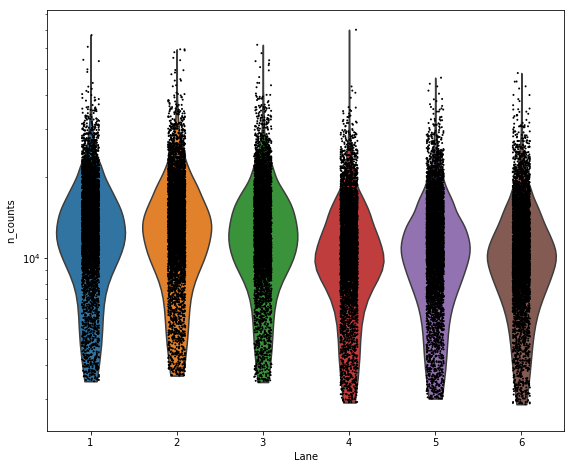

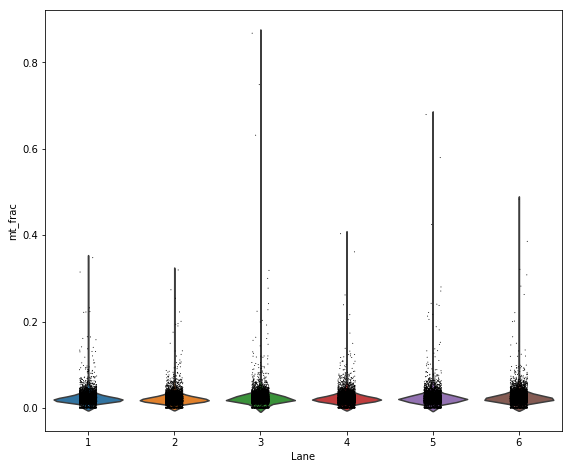

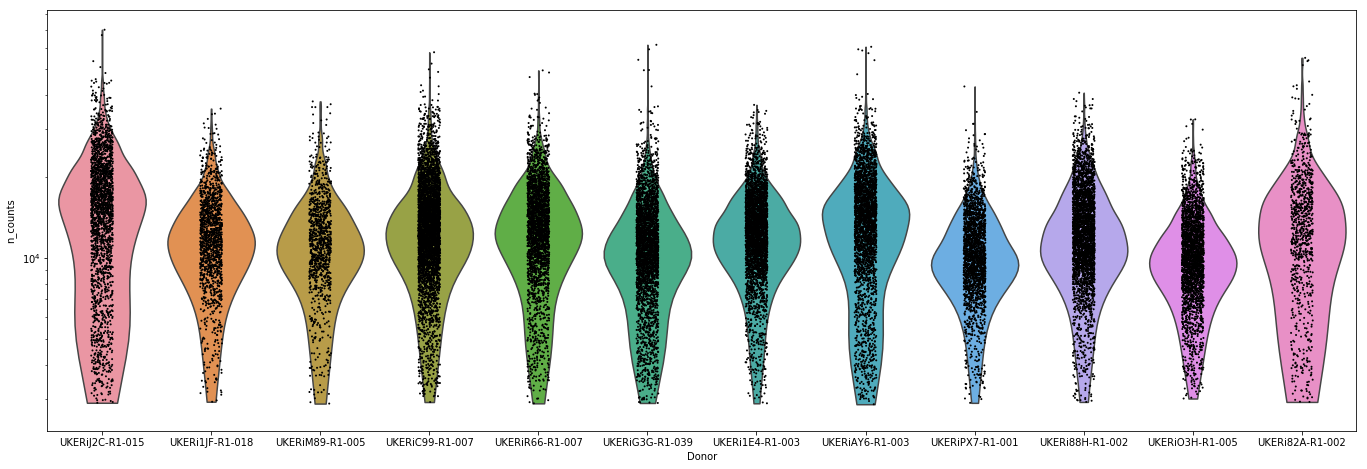

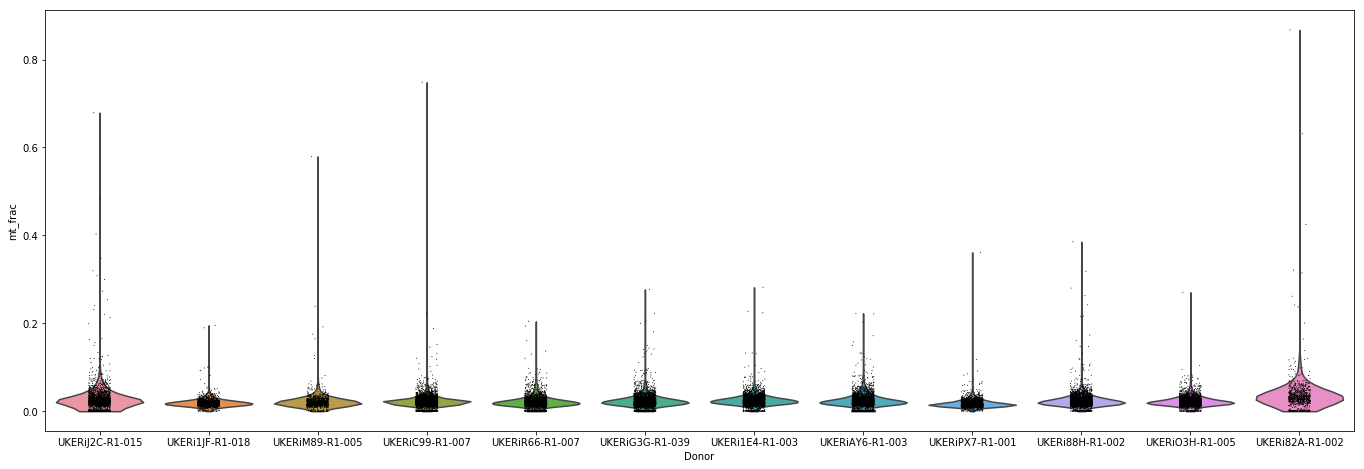

In [9]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata_pat, 'n_counts', groupby='Lane', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata_pat, 'mt_frac', groupby='Lane')

plt.rcParams['figure.figsize']=(18,8) #rescale figures
t3 = sc.pl.violin(adata_pat, 'n_counts', groupby='Donor', size=2, log=True, cut=0)
t4 = sc.pl.violin(adata_pat, 'mt_frac', groupby='Donor', cut=0)
plt.rcParams['figure.figsize']=(8,8) #rescale figures

Data are consistent across lanes, and broadly across Donors. We can filter cells and genes jointly given the above results.

In [10]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0.2, 1, 150))
colors3 = plt.cm.Greys_r(np.linspace(0.5,0.55,30))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

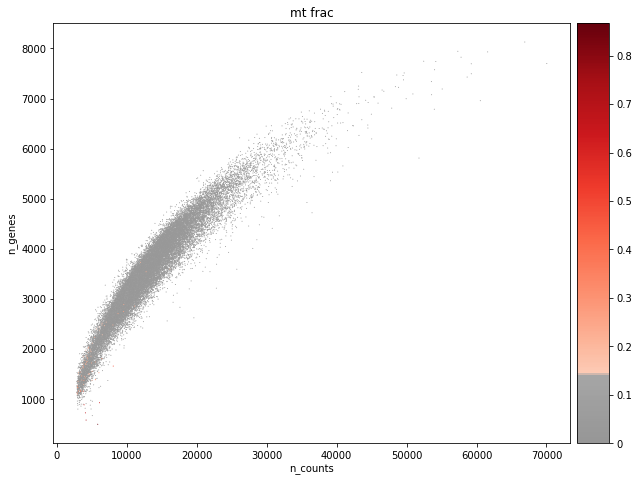

/home/icb/malte.luecken/new_anndata/anndata/anndata/core/anndata.py:1427: ImplicitModificationWarning: Initializing view as actual.
  ImplicitModificationWarning,


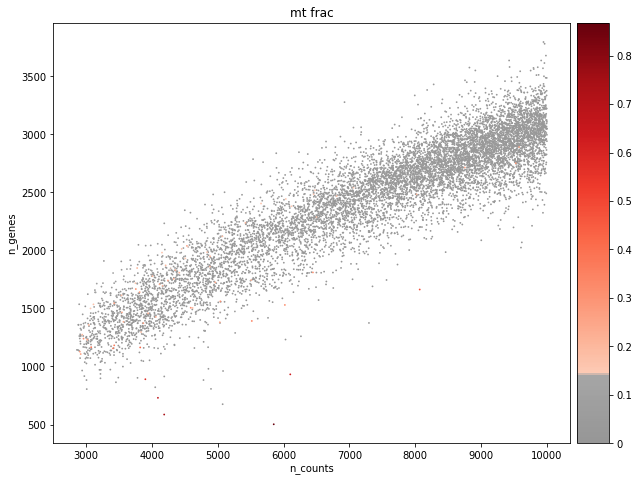

In [11]:
#Data quality summary plots
p1 = sc.pl.scatter(adata_pat, 'n_counts', 'n_genes', color='mt_frac', color_map=mymap)
p2 = sc.pl.scatter(adata_pat[adata_pat.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', color_map=mymap)


Here it looks like n_genes < 1000 should be filtered out, and counts are all fine.

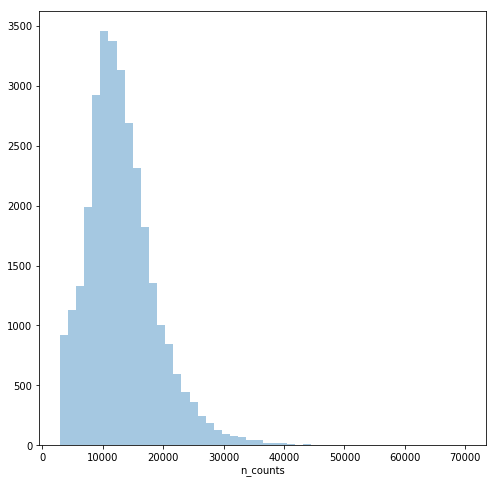

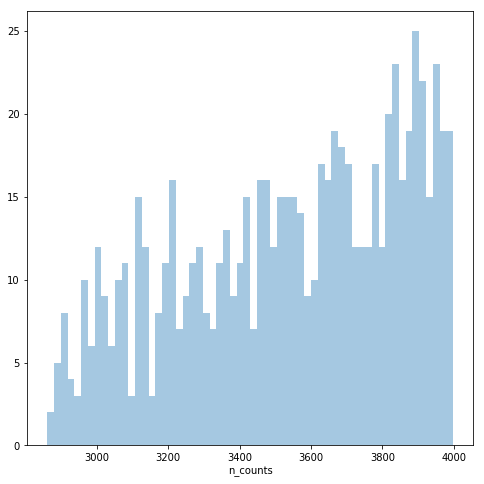

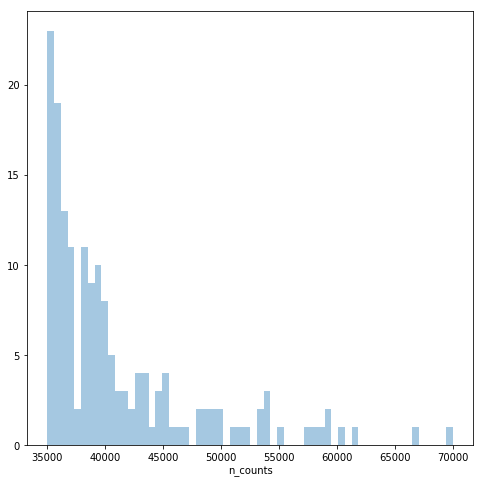

In [12]:
#Thresholding decision: counts
p3 = sb.distplot(adata_pat.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata_pat.obs['n_counts'][adata_pat.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata_pat.obs['n_counts'][adata_pat.obs['n_counts']>35000], kde=False, bins=60)
plt.show()

Count thresholding has already happened by CellRanger. No further thresholding is necessary!

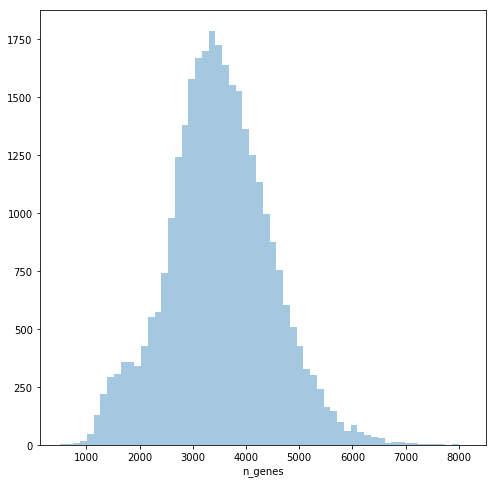

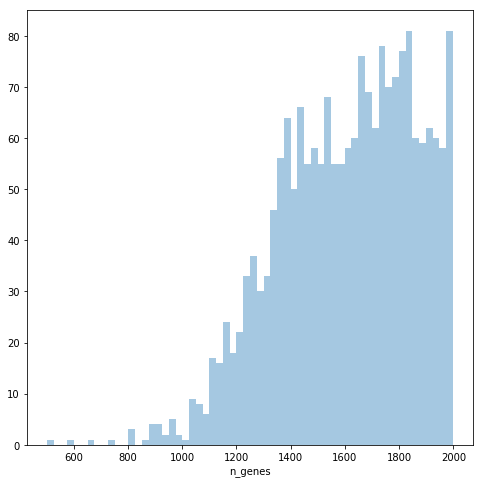

In [13]:
#Thresholding decision: genes
p6 = sb.distplot(adata_pat.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata_pat.obs['n_genes'][adata_pat.obs['n_genes']<2000], kde=False, bins=60)
plt.show()


In [14]:
# Create a nice QC plot for the paper
adata_pat.obs['Total counts'] = adata_pat.obs['n_counts']
adata_pat.obs['Number of genes'] = adata_pat.obs['n_genes']

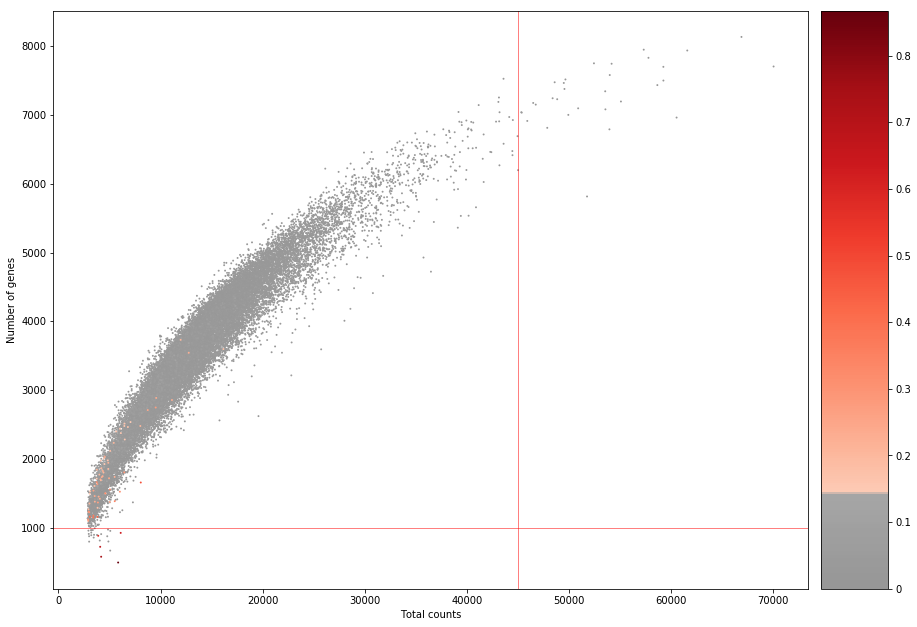

In [15]:
# QC plot for manuscript
plt.rcParams['figure.figsize']=(11,11) #rescale figures
p1 = sc.pl.scatter(adata_pat, 'Total counts', 'Number of genes', color_map=mymap, color='mt_frac', show=False, title="", size=15)
p1.axvline(45000,0,9000, color='red', linewidth=0.5)
p1.axhline(1000,0,75000, color='red', linewidth=0.5)
plt.savefig('../figures/scatter_figure_qcplot_thresholds.svg')
plt.rcParams['figure.figsize']=(8,8) #rescale figures

In [16]:
#Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata_pat.n_obs))

sc.pp.filter_cells(adata_pat, max_counts = 45000)
print('Number of cells after max count filter: {:d}'.format(adata_pat.n_obs))

adata_pat = adata_pat[adata_pat.obs['mt_frac'] < 0.15]
print('Number of cells after MT filter: {:d}'.format(adata_pat.n_obs))

sc.pp.filter_cells(adata_pat, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata_pat.n_obs))

Total number of cells: 30676
filtered out 32 cells that havemore than 45000 counts
Number of cells after max count filter: 30644
Number of cells after MT filter: 30577
filtered out 20 cells that haveless than 1000 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 30557


In [17]:
#Filter cells according to ambiguous reads and doublets
print('Total number of cells: {:d}'.format(adata_pat.n_obs))

adata_pat = adata_pat[adata_pat.obs['Demux_state'] == 'SNG', :]
print('Number of cells after demux filter: {:d}'.format(adata_pat.n_obs))


Total number of cells: 30557
Number of cells after demux filter: 30557


In [18]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata_pat.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_pat, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_pat.n_vars))

Total number of genes: 58735
filtered out 33815 genes that are detectedin less than 20 cells


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 24920


# Normalization

In [19]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata_pat.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)


normalizing by total count per cell
    finished (0:00:19): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 15


/home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$16.16', defined at /home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/umap/rp_tree.py (457)

File "../../../../../../../../../../../home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, lea

    finished (0:00:11)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:09)


In [20]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata_pat.X.T

In [21]:
%R .libPaths(.libPaths()[c(3,2)])

array(['/home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/R/library',
       '/home/icb/malte.luecken/R/x86_64-pc-linux-gnu-library/3.5'],
      dtype='<U64')

In [22]:
%%R -i data_mat -i input_groups -o size_factors
require(scran)

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [23]:
#Delete adata_pat_pp
del adata_pp

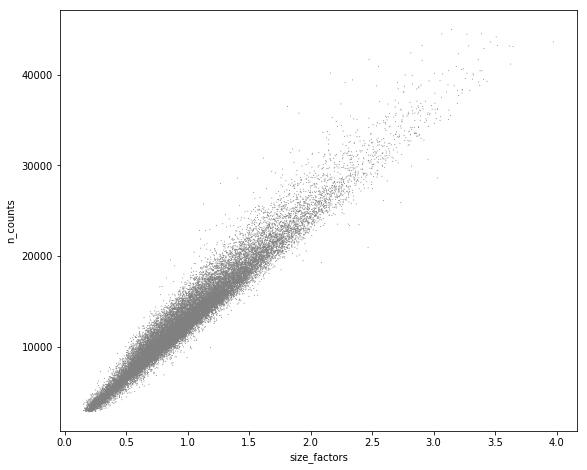

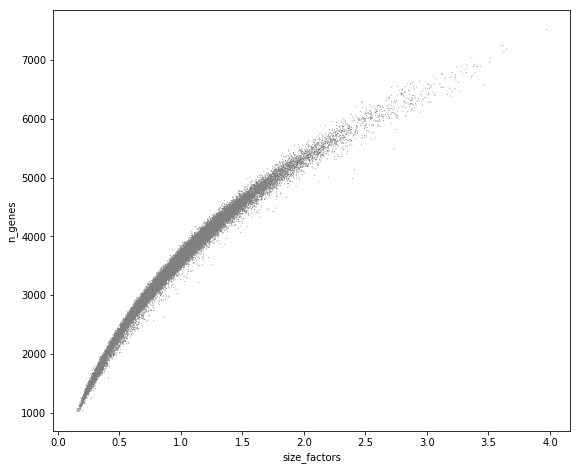

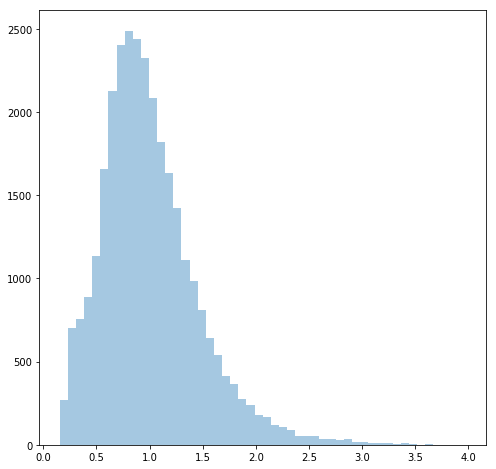

In [24]:
# Visualize the estimated size factors
adata_pat.obs['size_factors'] = size_factors

sc.pl.scatter(adata_pat, 'size_factors', 'n_counts')
sc.pl.scatter(adata_pat, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

We plot the size factors to show they are non-negative and related to the number of counts and genes per cell as expected.

In [25]:
#Keep the count data in a counts layer
adata_pat.layers["counts"] = adata_pat.X.copy()

In [26]:
#Normalize adata_pat 
adata_pat.X /= adata_pat.obs['size_factors'].values[:,None]
sc.pp.log1p(adata_pat)

In [27]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata_pat.raw = adata_pat

# Data summary statistics

In [28]:
adata_pat.obs['Donor'].value_counts()

UKERiC99-R1-007    4582
UKERi1E4-R1-003    3446
UKERi88H-R1-002    3279
UKERiG3G-R1-039    3232
UKERiAY6-R1-003    2979
UKERiO3H-R1-005    2746
UKERiR66-R1-007    2693
UKERiJ2C-R1-015    2163
UKERiPX7-R1-001    2157
UKERi1JF-R1-018    1394
UKERiM89-R1-005    1034
UKERi82A-R1-002     852
Name: Donor, dtype: int64

In [29]:
#Recalculate total counts after filtering
adata_pat.obs['total_counts'] = adata_pat.layers['counts'].sum(1)

In [30]:
adata_pat.obs.groupby(by='Donor')['total_counts'].median()

Donor
UKERiJ2C-R1-015    15820.0
UKERi1JF-R1-018    12052.0
UKERiM89-R1-005    11693.5
UKERiC99-R1-007    13102.0
UKERiR66-R1-007    13293.0
UKERiG3G-R1-039    11062.0
UKERi1E4-R1-003    12628.0
UKERiAY6-R1-003    14244.0
UKERiPX7-R1-001    10390.0
UKERi88H-R1-002    12508.0
UKERiO3H-R1-005    10220.0
UKERi82A-R1-002    13369.5
Name: total_counts, dtype: float32

# Highly Variable Genes

In [31]:
# Check highly variable gene selection to look at the results
sc.pp.highly_variable_genes(adata_pat, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata_pat.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


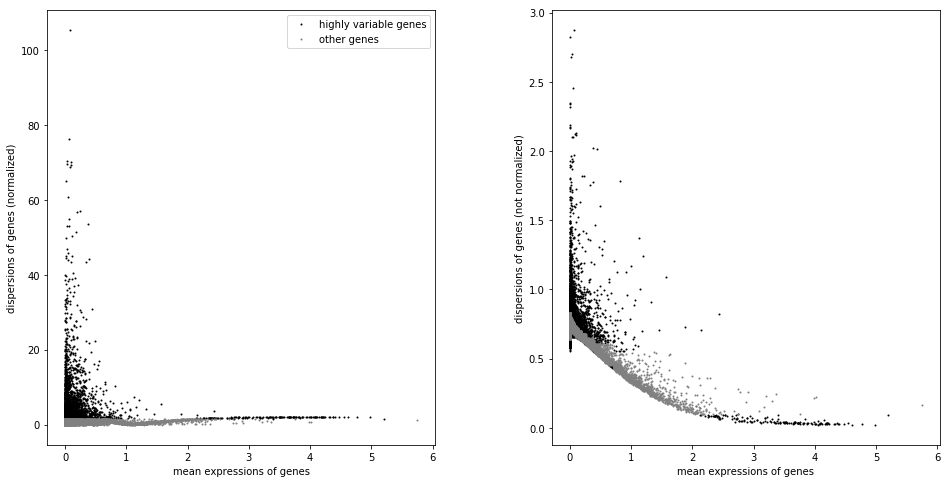

In [32]:
#Plot the highly variable genes
sc.pl.highly_variable_genes(adata_pat)

# Dimensionality reduction (summarization)

In [33]:
sc.pp.pca(adata_pat, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_pat)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/icb/malte.luecken/.local/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../../home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished (0:00:07)


# Visualize unintegrated data

In [34]:
sc.tl.umap(adata_pat)

computing UMAP
    finished (0:00:30)


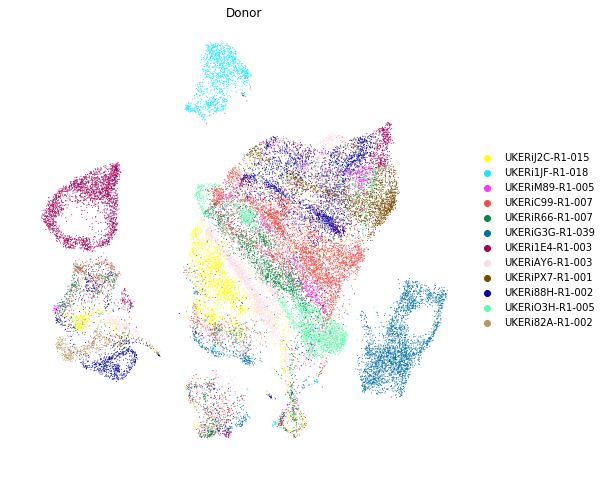

In [36]:
sc.pl.umap(adata_pat, color='Donor', use_raw=True, palette=sc.pl.palettes.godsnot_64, frameon=False, save='_unintegrated_donor.svg')

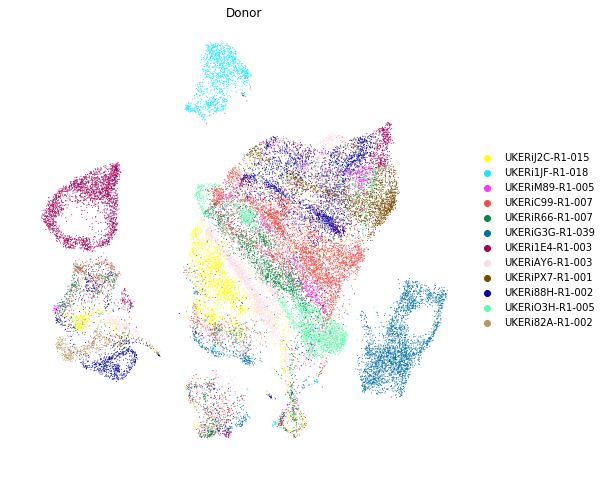

In [37]:
sc.pl.umap(adata_pat, color='Donor', use_raw=True, palette=sc.pl.palettes.godsnot_64, frameon=False, save='_unintegrated_donor.png')

# MNN Data integration

In [34]:
datasets = [adata_pat[adata_pat.obs['Donor'] == d,:].copy() for d in adata_pat.obs['Donor'].cat.categories]

In [35]:
len(datasets)

12

In [36]:
datasets[0]

AnnData object with n_obs × n_vars = 2163 × 24920 
    obs: 'Demux_state', 'Donor', 'Lane', 'condition', 'age', 'years_of_illness', 'gender', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'Total counts', 'Number of genes', 'size_factors', 'total_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [37]:
for d in datasets:
    sc.pp.highly_variable_genes(d, n_top_genes=6000, flavor='cell_ranger', inplace=True)
    
hvgs = [set(d.var_names[d.var['highly_variable']]) for d in datasets]

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes


/home/icb/malte.luecken/new_scanpy/scanpy/scanpy/preprocessing/_highly_variable_genes.py:135: RuntimeWarning: divide by zero encountered in true_divide
  ) / disp_mad_bin[df['mean_bin'].values].values
/home/icb/malte.luecken/new_scanpy/scanpy/scanpy/preprocessing/_highly_variable_genes.py:135: RuntimeWarning: invalid value encountered in true_divide
  ) / disp_mad_bin[df['mean_bin'].values].values


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes


/home/icb/malte.luecken/new_scanpy/scanpy/scanpy/preprocessing/_highly_variable_genes.py:135: RuntimeWarning: divide by zero encountered in true_divide
  ) / disp_mad_bin[df['mean_bin'].values].values
/home/icb/malte.luecken/new_scanpy/scanpy/scanpy/preprocessing/_highly_variable_genes.py:135: RuntimeWarning: invalid value encountered in true_divide
  ) / disp_mad_bin[df['mean_bin'].values].values


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished

/home/icb/malte.luecken/new_scanpy/scanpy/scanpy/preprocessing/_highly_variable_genes.py:135: RuntimeWarning: divide by zero encountered in true_divide
  ) / disp_mad_bin[df['mean_bin'].values].values
/home/icb/malte.luecken/new_scanpy/scanpy/scanpy/preprocessing/_highly_variable_genes.py:135: RuntimeWarning: invalid value encountered in true_divide
  ) / disp_mad_bin[df['mean_bin'].values].values


In [38]:
# Total number of HVGs found per dataset
[len(i) for i in hvgs]

[6000, 6000, 5999, 5999, 6000, 5999, 5999, 5999, 6459, 6000, 5999, 5999]

In [39]:
# Take the intersection of the HVGs to calculate mutual nearest neighbours for MNN data integration
hvg_intersect = hvgs[0].intersection(*hvgs[1:12])
len(hvg_intersect)

521

In [40]:
adata_pat_mnn = sce.pp.mnn_correct(*datasets, var_subset=list(hvg_intersect), batch_key="donor")

/home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: Invalid use of Function(<function norm at 0x7f3b6c164840>) with argument(s) of type(s): (axis=Literal[int](1), x=array(float32, 2d, A))
 * parameterized
In definition 0:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /home/icb/malte.luecken/.local/lib/python3.6/site-packages/numba/typing/templates.py:539
In definition 1:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /home/icb/malte.luecken/.local/lib/python3.6/site-packages/numba/typing/templates.py:539
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function norm at 0x7f3b6c164840>)
[2] During: typing of call at /home/icb/malte.lue

Performing cosine normalization...


/home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: Invalid use of Function(<function norm at 0x7f3b6c164840>) with argument(s) of type(s): (axis=Literal[int](1), x=array(float32, 2d, A))
 * parameterized
In definition 0:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /home/icb/malte.luecken/.local/lib/python3.6/site-packages/numba/typing/templates.py:539
In definition 1:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /home/icb/malte.luecken/.local/lib/python3.6/site-packages/numba/typing/templates.py:539
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function norm at 0x7f3b6c164840>)
[2] During: typing of call at /home/icb/malte.lue

Starting MNN correct iteration. Reference batch: 0
Step 1 of 11: processing batch 1
  Looking for MNNs...


/home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/mnnpy/utils.py:88: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_mutual_nn" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at /home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/mnnpy/utils.py (94)

File "../../../../../../../../../../../home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  @jit((float32[:, :], float32[:, :], int8, int8, int8))
/home/icb/malte.luecken/.local/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "find_mutual_nn" was compiled in object mode without forceobj=True.

File "../../../../../../../../../../../home/icb/malte.luecken/anaconda3

  Computing correction vectors...


/home/icb/malte.luecken/.local/lib/python3.6/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'mnn2' of function 'compute_correction'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../../../../../../home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/mnnpy/utils.py", line 107:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/mnnpy/utils.py:102: NumbaWarning: 
Compilation is falling back to object mode WITHOUT loop

  Adjusting variance...
  Applying correction...
Step 2 of 11: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 3 of 11: processing batch 3
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 4 of 11: processing batch 4
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 5 of 11: processing batch 5
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 6 of 11: processing batch 6
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 7 of 11: processing batch 7
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 8 of 11: processing batch 8
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying

## HVGs & Dimensionality reduction on MNN integrated data

In [41]:
mnn_pairing = adata_pat_mnn[1]
adata_pat_mnn = adata_pat_mnn[0]

In [42]:
# Similar obs names
adata_pat_mnn.obs_names = [idx.split('-')[0] for idx in adata_pat_mnn.obs_names]

In [43]:
# Add raw data again
adata_pat_mnn.raw = sc.AnnData(X = adata_pat[adata_pat_mnn.obs_names].X,
                               obs = pd.DataFrame(index=adata_pat_mnn.obs_names), 
                               var = pd.DataFrame(index=adata_pat_mnn.var_names))

In [44]:
adata_pat_mnn.var.columns

Index(['n_cells', 'highly_variable-0', 'means-0', 'dispersions-0',
       'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1',
       'dispersions_norm-1', 'highly_variable-2', 'means-2', 'dispersions-2',
       'dispersions_norm-2', 'highly_variable-3', 'means-3', 'dispersions-3',
       'dispersions_norm-3', 'highly_variable-4', 'means-4', 'dispersions-4',
       'dispersions_norm-4', 'highly_variable-5', 'means-5', 'dispersions-5',
       'dispersions_norm-5', 'highly_variable-6', 'means-6', 'dispersions-6',
       'dispersions_norm-6', 'highly_variable-7', 'means-7', 'dispersions-7',
       'dispersions_norm-7', 'highly_variable-8', 'means-8', 'dispersions-8',
       'dispersions_norm-8', 'highly_variable-9', 'means-9', 'dispersions-9',
       'dispersions_norm-9', 'highly_variable-10', 'means-10',
       'dispersions-10', 'dispersions_norm-10', 'highly_variable-11',
       'means-11', 'dispersions-11', 'dispersions_norm-11'],
      dtype='object')

In [45]:
adata_pat_mnn.var = adata_pat_mnn.var.drop(columns=adata_pat_mnn.var.columns)

In [46]:
# Run highly variable gene selection on integrated data and look at the results
sc.pp.highly_variable_genes(adata_pat_mnn, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata_pat.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


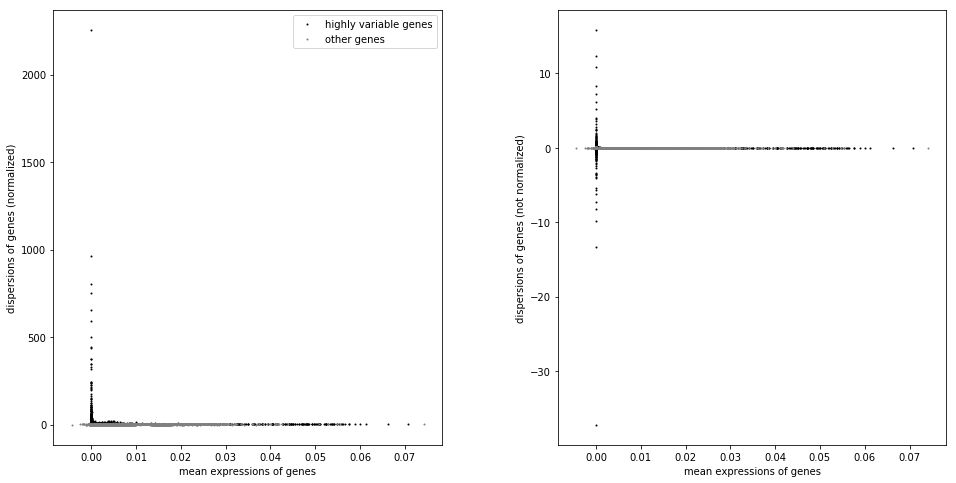

In [47]:
#Plot the highly variable genes
sc.pl.highly_variable_genes(adata_pat_mnn)

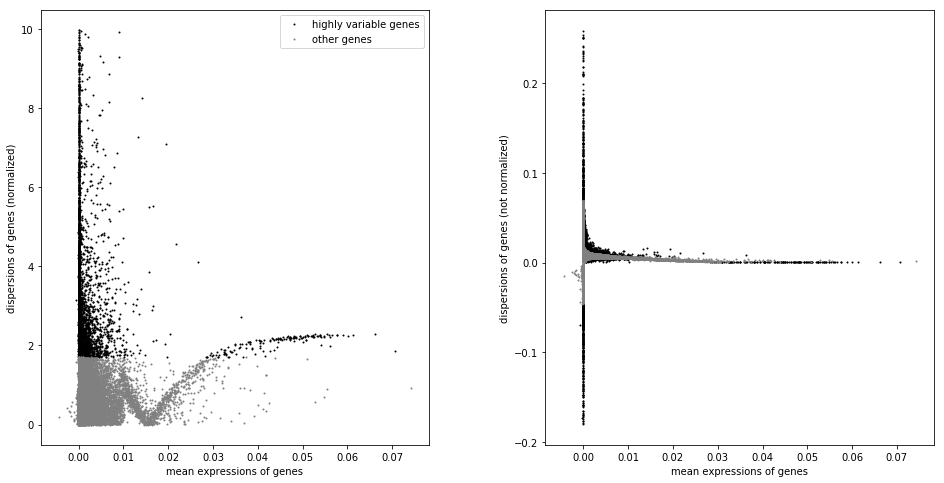

In [48]:
test = adata_pat_mnn[:,np.flatnonzero(adata_pat_mnn.var["dispersions_norm"] < 10)].copy()
sc.pl.highly_variable_genes(test)


In [49]:
sc.pp.pca(adata_pat_mnn, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata_pat_mnn)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:12)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/icb/malte.luecken/.local/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../../home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished (0:00:13)


# Visualization

In [50]:
# Calculate the visualizations
sc.tl.umap(adata_pat_mnn)

computing UMAP
    finished (0:00:49)


... storing 'Donor' as categorical
... storing 'condition' as categorical
... storing 'gender' as categorical


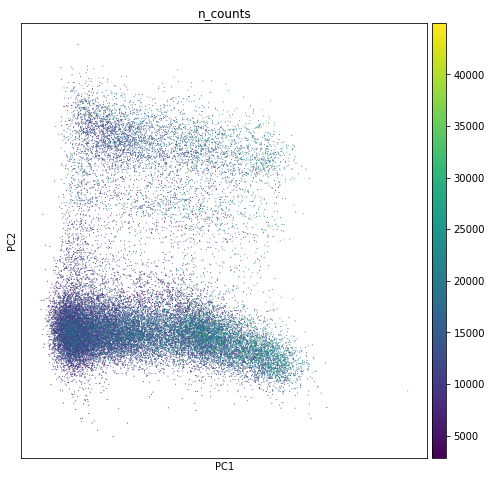

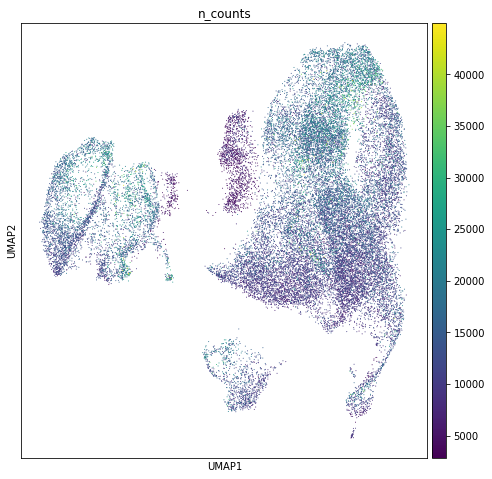

In [51]:
sc.pl.pca_scatter(adata_pat_mnn, color='n_counts', use_raw=False)
sc.pl.umap(adata_pat_mnn, color='n_counts', use_raw=False)

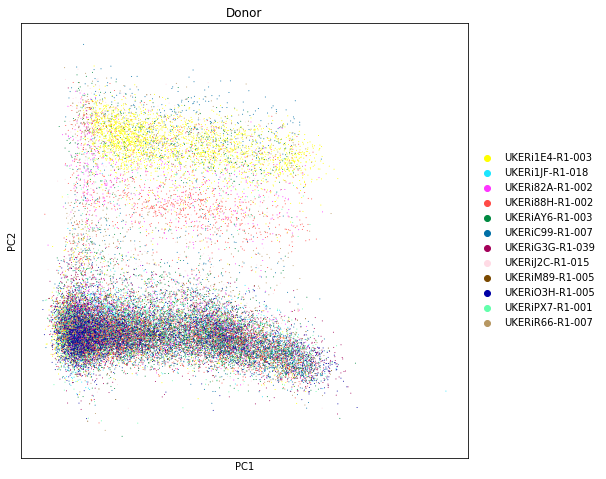

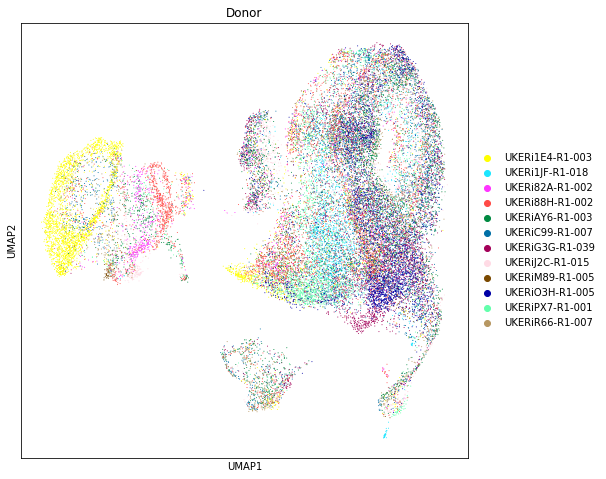

In [52]:
sc.pl.pca_scatter(adata_pat_mnn, color='Donor', use_raw=False, palette=sc.pl.palettes.godsnot_64)
sc.pl.umap(adata_pat_mnn, color='Donor', use_raw=False, palette=sc.pl.palettes.godsnot_64)

# Cell cycle scoring

In [53]:
#Score cell cycle and visualize the effect:
cell_cycle_genes = [x.strip() for x in open(cc_genes_tirosh)]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_pat_mnn.var_names]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]


sc.tl.score_genes_cell_cycle(adata_pat_mnn, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:07)
computing score 'G2M_score'
    finished (0:00:07)
-->     'phase', cell cycle phase (adata.obs)


... storing 'phase' as categorical


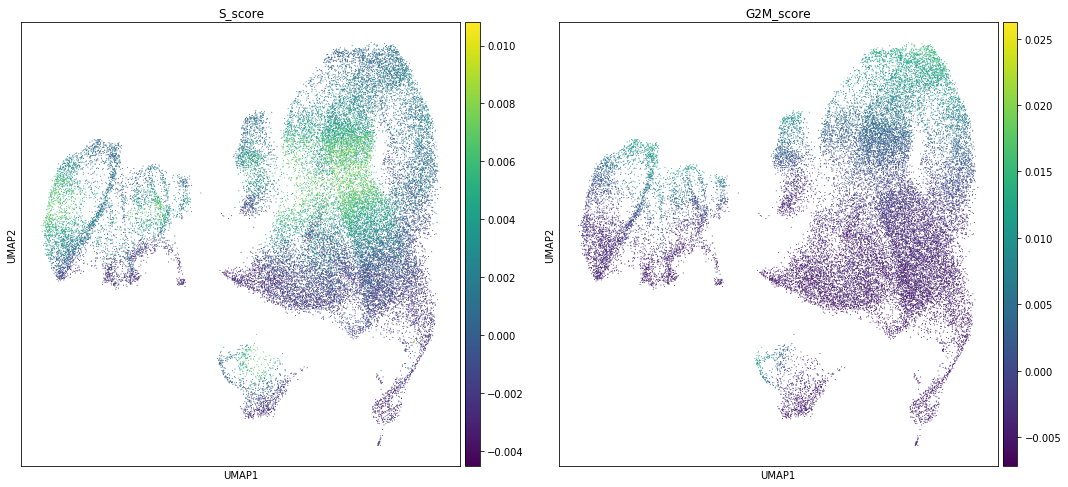

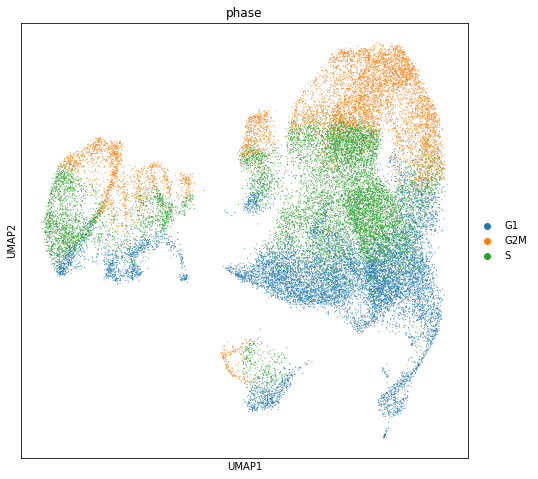

In [54]:
# Tirosh CC gene scoring
sc.pl.umap(adata_pat_mnn, color=['S_score', 'G2M_score'])
sc.pl.umap(adata_pat_mnn, color='phase')

In [55]:
adata_pat_mnn.obs.phase.value_counts()

S      12333
G1     10738
G2M     7486
Name: phase, dtype: int64

# Clustering

In [56]:
# Perform clustering
sc.tl.louvain(adata_pat_mnn, key_added='louvain_r1')
sc.tl.louvain(adata_pat_mnn, resolution=0.5, key_added='louvain_r0.5')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:06)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:05)


In [57]:
adata_pat_mnn.obs['louvain_r0.5'].value_counts()
adata_pat_mnn.obs['louvain_r1'].value_counts()

0    7231
1    5180
2    4987
3    4354
4    3202
5    2001
6    1369
7     981
8     754
9     498
Name: louvain_r0.5, dtype: int64

0     3675
1     2976
2     2932
3     2717
4     2705
5     2443
6     1873
7     1776
8     1748
9     1383
10    1292
11    1063
12    1060
13     982
14     978
15     954
Name: louvain_r1, dtype: int64

In [58]:
adata_pat_mnn.obs['louvain_r0.5'].value_counts()
adata_pat_mnn.obs['louvain_r1'].value_counts()

0    7231
1    5180
2    4987
3    4354
4    3202
5    2001
6    1369
7     981
8     754
9     498
Name: louvain_r0.5, dtype: int64

0     3675
1     2976
2     2932
3     2717
4     2705
5     2443
6     1873
7     1776
8     1748
9     1383
10    1292
11    1063
12    1060
13     982
14     978
15     954
Name: louvain_r1, dtype: int64

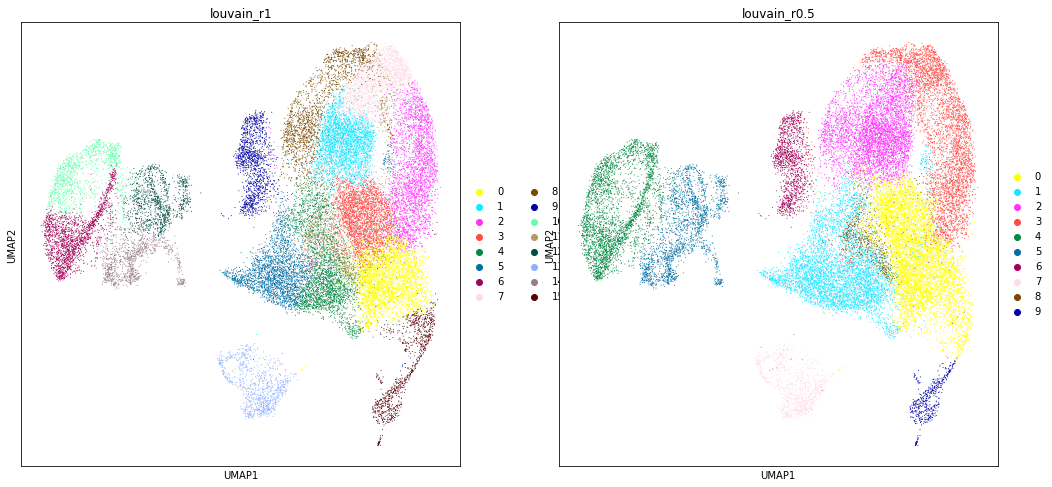

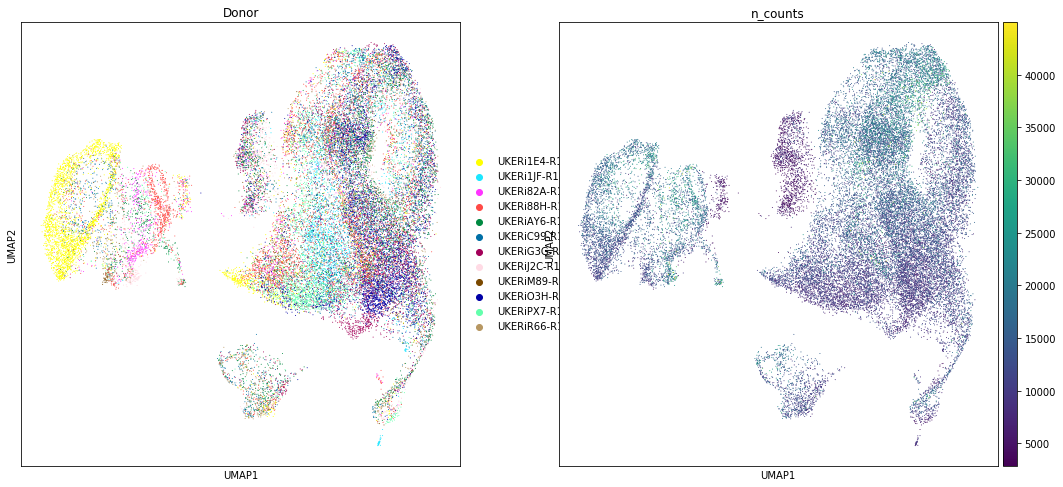

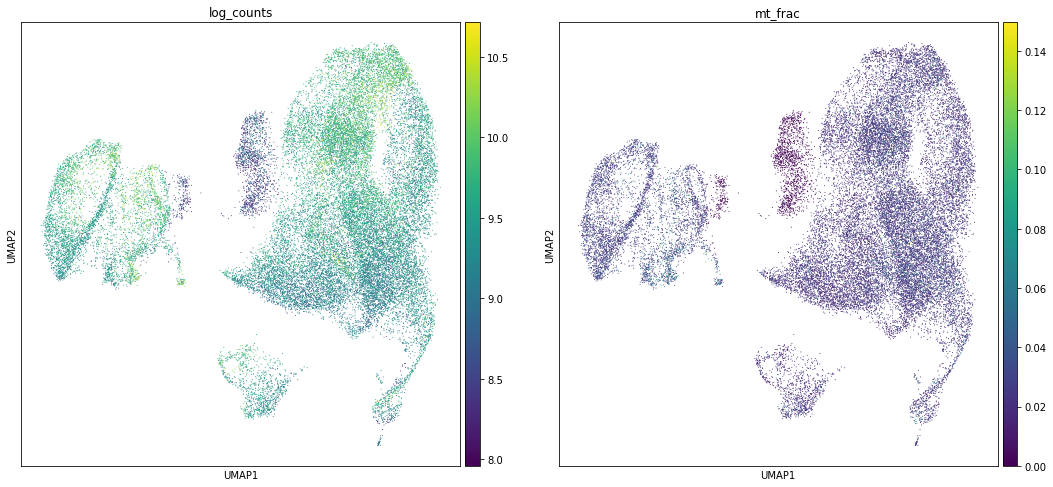

In [59]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata_pat_mnn, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64)
sc.pl.umap(adata_pat_mnn, color=['Donor', 'n_counts'])
sc.pl.umap(adata_pat_mnn, color=['log_counts', 'mt_frac'])

# Low-res clustering

In [60]:
sc.tl.louvain(adata_pat_mnn, resolution=0.2, key_added='louvain_r0.2')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:05)


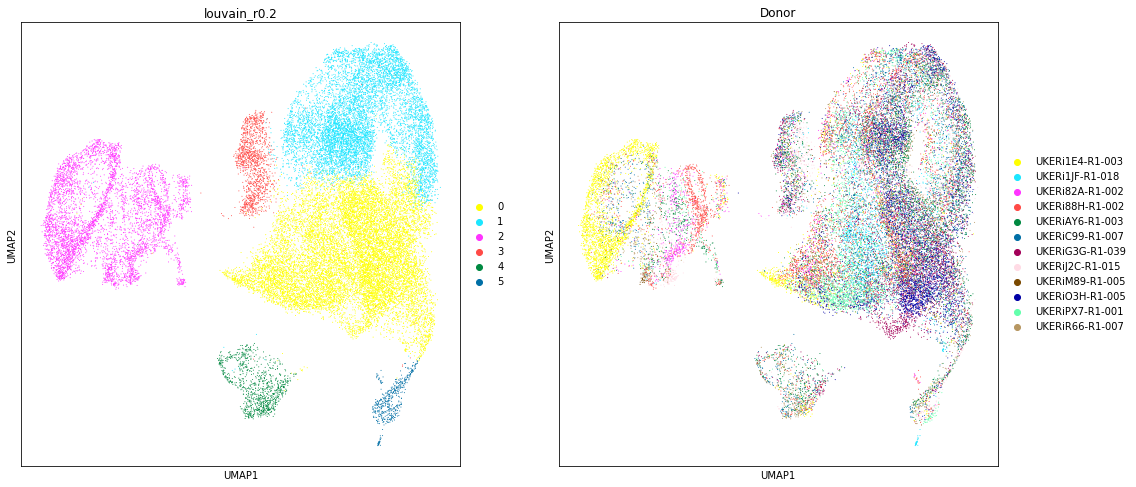

In [61]:
sc.pl.umap(adata_pat_mnn, color=['louvain_r0.2', 'Donor'], palette=sc.pl.palettes.godsnot_64)

# Write data to file

In [62]:
adata_pat_mnn.write(adata_out)